In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Dataset

In [2]:
def inf_train_gen(n_grid_points: int = 128, batch_size: int = 200, device: str = "cpu") -> Tensor:
    assert n_grid_points % 4 == 0, "number of grid points has to be divisible by 4"
    
    n_grid_points = n_grid_points // 4
    
    x1 = torch.randint(low=0, high=n_grid_points * 4, size=(batch_size,), device=device)
    samples_x2 = torch.randint(low=0, high=n_grid_points, size=(batch_size,), device=device)
    
    x2 = (
        samples_x2
        + 2 * n_grid_points
        - torch.randint(low=0, high=2, size=(batch_size,), device=device) * 2 * n_grid_points
        + (torch.floor(x1 / n_grid_points) % 2) * n_grid_points
    )
    
    x_end = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1)

    return x_end.long()

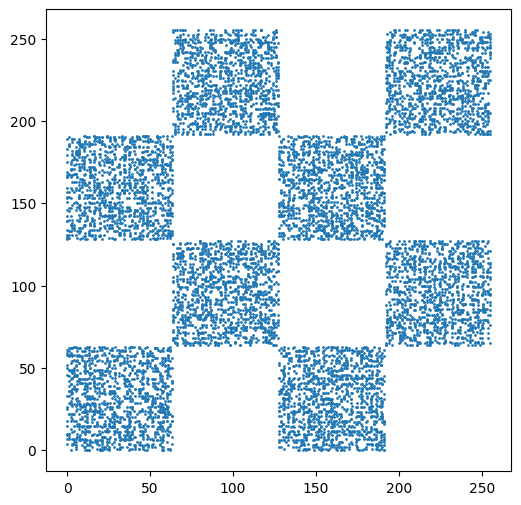

In [3]:
# Visulize dataset
samples = inf_train_gen(256, 10000)
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

## Training

In [4]:
from models.discrete_diffusion.udm import UniformDiffusion
from models.discrete_diffusion.utils.parametrizations import subs_parametrization
from models.denoising_models.mlp import MLP

batch_size = 64
train_steps = 20000
vocab_size = 256
num_categories = vocab_size
input_shape = (2,)
num_timesteps = 1000
lr = 1e-3

model = UniformDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=256,
        encode_time=True,
        n_hidden_layers=1,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    noise_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_steps)

Step 100/20000, Loss (EWMA): 12.0254, LR: 0.001000
Step 200/20000, Loss (EWMA): 11.9454, LR: 0.001000
Step 300/20000, Loss (EWMA): 11.8222, LR: 0.000999
Step 400/20000, Loss (EWMA): 11.7001, LR: 0.000999
Step 500/20000, Loss (EWMA): 11.7335, LR: 0.000998
Step 600/20000, Loss (EWMA): 11.5961, LR: 0.000998
Step 700/20000, Loss (EWMA): 11.5329, LR: 0.000997
Step 800/20000, Loss (EWMA): 11.4867, LR: 0.000996
Step 900/20000, Loss (EWMA): 11.4757, LR: 0.000995
Step 1000/20000, Loss (EWMA): 11.3982, LR: 0.000994
Step 1100/20000, Loss (EWMA): 11.3665, LR: 0.000993
Step 1200/20000, Loss (EWMA): 11.2919, LR: 0.000991
Step 1300/20000, Loss (EWMA): 11.2368, LR: 0.000990
Step 1400/20000, Loss (EWMA): 11.1687, LR: 0.000988
Step 1500/20000, Loss (EWMA): 11.1116, LR: 0.000986
Step 1600/20000, Loss (EWMA): 11.1034, LR: 0.000984
Step 1700/20000, Loss (EWMA): 11.1730, LR: 0.000982
Step 1800/20000, Loss (EWMA): 11.1729, LR: 0.000980
Step 1900/20000, Loss (EWMA): 11.1326, LR: 0.000978
Step 2000/20000, Loss

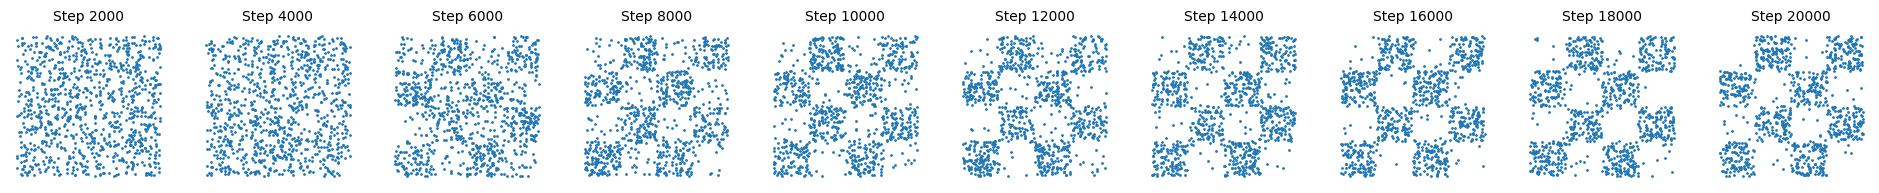

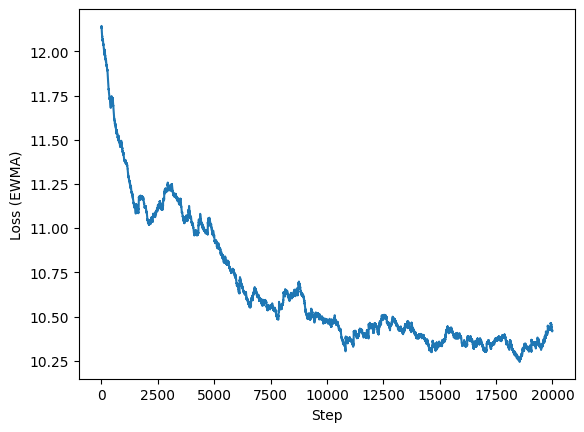

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(24, 2))
fig_idx = 0

losses = []
loss_ewma = None

for step in range(train_steps):
    x = inf_train_gen(n_grid_points=vocab_size, batch_size=batch_size, device=device)
    
    model.train()
    optimizer.zero_grad()
    loss = model(x)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if loss_ewma is None:
        loss_ewma = loss.item()
    else:
        loss_ewma = 0.999 * loss_ewma + 0.001 * loss.item()
    losses.append(loss_ewma)
    
    if (step + 1) % 100 == 0:
        print(f"Step {step + 1}/{train_steps}, Loss (EWMA): {loss_ewma:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if (step + 1) % (train_steps // 10) == 0:
        model.eval()
        with torch.no_grad():
            samples = model.sample(num_samples=1000, device=device).cpu().numpy()
        ax[fig_idx].scatter(samples[:, 0], samples[:, 1], s=1)
        ax[fig_idx].set_title(f"Step {step + 1}", fontsize=10)
        ax[fig_idx].axis('off')
        fig_idx += 1
        
plt.show()

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss (EWMA)')
plt.show()

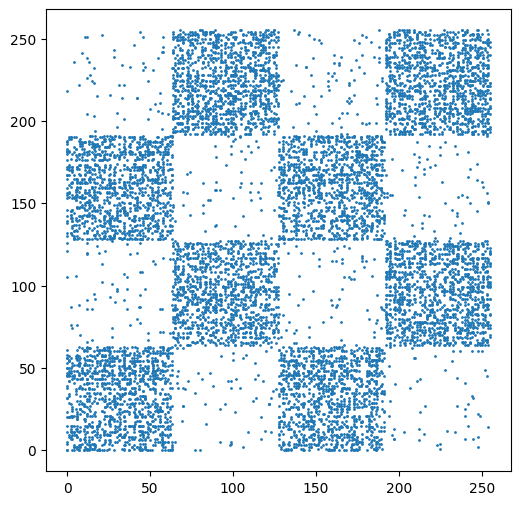

In [44]:
# Visualize model samples
model.eval()
with torch.no_grad():
    samples = model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

In [45]:
# store model weights
torch.save(model.state_dict(), '../model_weights/udm_checkerboard_256.pth')

Observed this weird quirk while training this model.
Given a point $(x, y)$, if x is between (0, 64), the denoising model gives high probability for y between (0, 64) and (64*2, 64*3), and vice versa when y is between (0, 64).

See below plots.

z_t


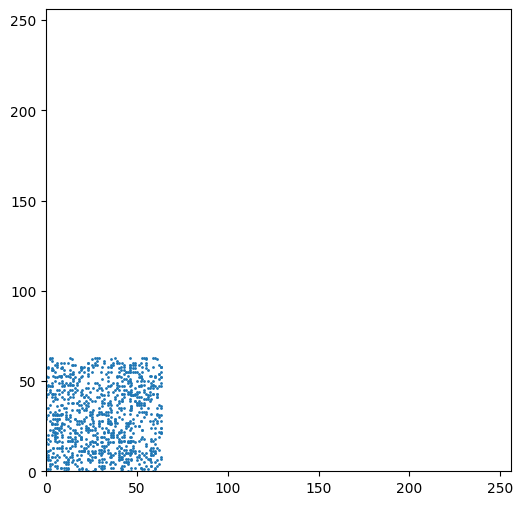

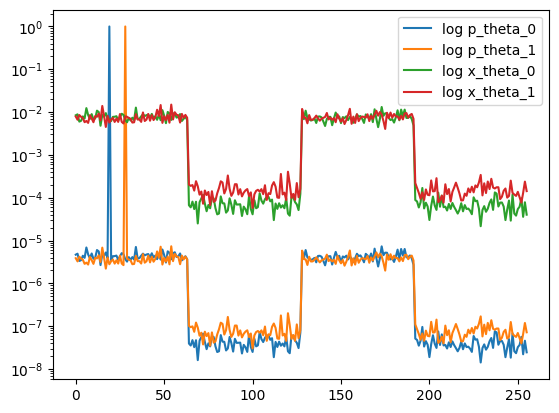

z_s


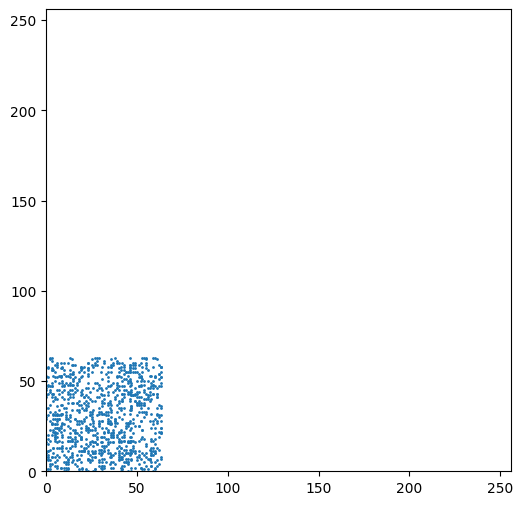

x_0


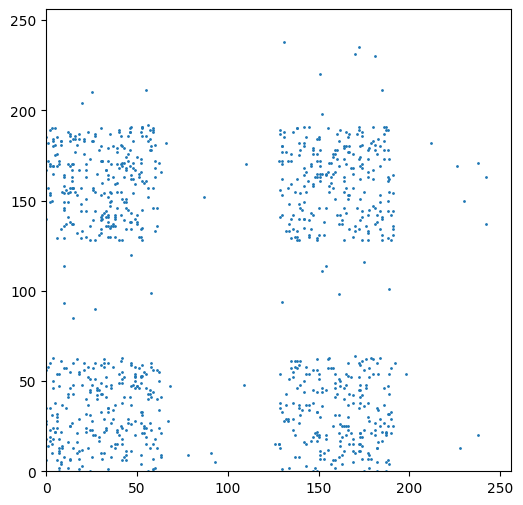

In [40]:
def plot(samples):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[:, 0], samples[:, 1], s=1)
    plt.xlim(0, 256)
    plt.ylim(0, 256)
    plt.show()

points = torch.randint(0, vocab_size//4, (1000, 2)) + torch.tensor([0 * vocab_size//4, 0 * vocab_size//4])
print("z_t")
plot(points)

p_theta, x_theta = model.sample_step(F.one_hot(points, num_classes=num_categories).float().to(device), 2, device=device)
p_theta, x_theta = p_theta.detach().cpu(), x_theta.detach().cpu()

# lets look at the probability distribution of a single point
r = 200
plt.plot(torch.arange(256), p_theta[r, 0, :].cpu(), label="log p_theta_0")
plt.plot(torch.arange(256), p_theta[r, 1, :].cpu(), label="log p_theta_1")
plt.plot(torch.arange(256), x_theta[r, 0, :].cpu(), label="log x_theta_0")
plt.plot(torch.arange(256), x_theta[r, 1, :].cpu(), label="log x_theta_1")
plt.yscale('log')
plt.legend()
plt.show()

print("z_s")
z_s = torch.distributions.Categorical(probs=p_theta).sample().cpu() # Shape: (B, L)
plot(z_s)

print("x_0")
x_0 = torch.distributions.Categorical(probs=x_theta).sample().cpu() # Shape: (B, L)
plot(x_0)

This quirk of the learned denoising model will likely be problematic when using samples from $x \sim x_\theta(z_t)$ to estimate rewards for $z_t$.

My intution is that the model loss is dominated by terms where $\alpha$ is small, since we have weighted sum with weight equal to $\alpha'(t)/\alpha(t)$ of the loss terms.

When, $\alpha(t)$ is low its very likely that either one of the coords (x or y) has changed or both have changed. The previously shown behaviour is the best guess of the model if given one the coords (x or y) has changed without the information whether it is x or y which has changed.

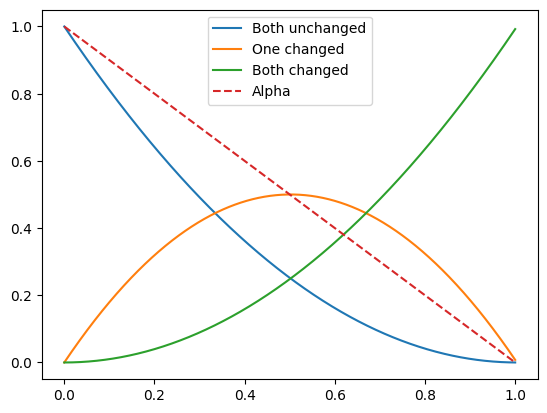

In [43]:
t = torch.linspace(0, 1, 1000)
alpha_t = model.scheduler.alpha(t)
weight = - model.scheduler.alpha_dash(t) / model.scheduler.alpha(t).clamp(min=1e-8)

change_prob = (1 - 1 / num_categories) *  (1 - alpha_t)

both_unchanged = (1 - change_prob) * (1 - change_prob)
one_changed = change_prob * (1 - change_prob) * 2
both_changed = change_prob * change_prob

assert torch.allclose(both_unchanged + one_changed + both_changed, torch.ones_like(t))

plt.plot(t, both_unchanged, label='Both unchanged')
plt.plot(t, one_changed, label='One changed')
plt.plot(t, both_changed, label='Both changed')
plt.plot(t, alpha_t, label='Alpha', linestyle='--')
plt.legend()
plt.show()